Nhập thư viện

In [ ]:
# Cài đặt thư viện NeuralForecast
!pip install neuralforecast

In [ ]:
# Nhập các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Nhập các thành phần chính từ neuralforecast
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS

In [ ]:
# Lấy dữ liệu từ Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricgomes/global-fashion-retail-stores-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'global-fashion-retail-stores-dataset' dataset.
Path to dataset files: /kaggle/input/global-fashion-retail-stores-dataset


In [ ]:
# Lấy dữ liệu tệp transactions.csv
data = pd.read_csv(path+'/transactions.csv')

In [ ]:
data.head()

,Invoice ID,Line,Customer ID,Product ID,Size,Color,Unit Price,Quantity,Date,Discount,Line Total,Store ID,Employee ID,Currency,Currency Symbol,SKU,Transaction Type,Payment Method,Invoice Total
0,INV-US-001-03558761,1,47162,485,M,NaN,80.5,1,2023-01-01 15:42:00,0.0,80.5,1,7,USD,$,MASU485-M-,Sale,Cash,126.7
1,INV-US-001-03558761,2,47162,2779,G,NaN,31.5,1,2023-01-01 15:42:00,0.4,18.9,1,7,USD,$,CHCO2779-G-,Sale,Cash,126.7
2,INV-US-001-03558761,3,47162,64,M,NEUTRAL,45.5,1,2023-01-01 15:42:00,0.4,27.3,1,7,USD,$,MACO64-M-NEUTRAL,Sale,Cash,126.7
3,INV-US-001-03558762,1,10142,131,M,BLUE,70.0,1,2023-01-01 20:04:00,0.4,42.0,1,6,USD,$,FECO131-M-BLUE,Sale,Cash,77.0
4,INV-US-001-03558762,2,10142,716,L,WHITE,26.0,1,2023-01-01 20:04:00,0.0,26.0,1,6,USD,$,MAT-716-L-WHITE,Sale,Cash,77.0


Chuẩn hóa dữ liệu về doanh thu theo ngày

In [ ]:
# Chuẩn hóa ngày
data['Date'] = pd.to_datetime(data['Date'])
data['Date Normalize'] = data['Date'].dt.normalize()

In [ ]:
# Chuyển đổi đơn vị tiền tệ
exchange_rates = pd.DataFrame({
    "Currency": ["USD", "CNY", "GBP", "EUR"],
    "to_USD": [1.00, 0.14, 1.33, 1.16]
})
data_temp = data.merge(exchange_rates, on='Currency', how='left')
data_temp['to_USD'] = data_temp['to_USD'].fillna(1.0)
data['Line Total'] = data_temp['Line Total'] * data_temp['to_USD']
del data_temp

In [ ]:
# Tính doanh thu theo ngày
grouped_data = data.groupby('Date Normalize')['Line Total'].sum()
group_data_df = grouped_data.to_frame()

In [ ]:
group_data_df

,Line Total
Date Normalize,
2023-01-01,759856.5580
2023-01-02,177565.8705
2023-01-03,158566.6598
2023-01-04,164006.1005
2023-01-05,157792.9851
...,...
2025-03-14,312090.5200
2025-03-15,747498.5142
2025-03-16,770373.4691


In [ ]:
len(group_data_df)

808

Dữ liệu đầu vào

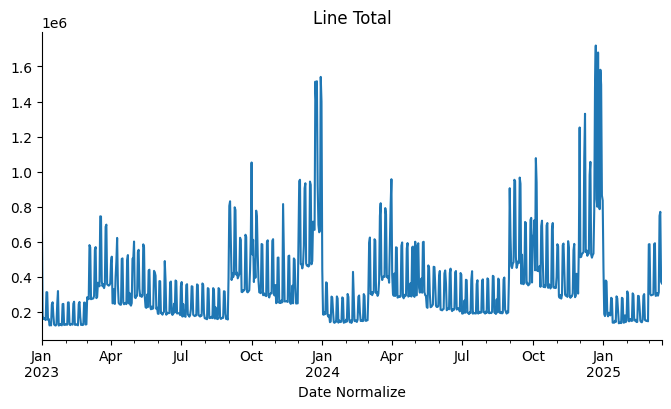

In [ ]:
group_data_df['Line Total'].plot(kind='line', figsize=(8, 4), title='Line Total')
plt.gca().spines[['top', 'right']].set_visible(False)

Tiền xử lý dữ liệu theo chuẩn đầu vào của NBEATS

In [ ]:
df_clean = group_data_df
df_clean = df_clean.reset_index()
df_clean = df_clean.rename(columns={'Date Normalize': 'ds'})
df_clean = df_clean.rename(columns={'Line Total': 'y'})
df_clean['unique_id'] = 'Total Sales'
df_final = df_clean[['unique_id', 'ds', 'y']]

In [ ]:
df_final.head()

,unique_id,ds,y
0,Total Sales,2023-01-01,759856.5580
1,Total Sales,2023-01-02,177565.8705
2,Total Sales,2023-01-03,158566.6598
3,Total Sales,2023-01-04,164006.1005
4,Total Sales,2023-01-05,157792.9851


In [ ]:
# Tính toán các tập train, validate và test
total_length = len(df_final)
test_size = int(total_length * 0.10) # 10% cho test
val_size = int(total_length * 0.20)  # 20% cho validation
train_size = total_length - test_size - val_size # Còn lại cho training

# Chia dữ liệu thành các tập train, val, test
test_df = df_final.iloc[-test_size:]
train_df = df_final.iloc[:-test_size]
val_df = train_df.iloc[-val_size:]

In [ ]:
HORIZON = test_size      # Chúng ta muốn dự đoán n ngày tới cho tập validation
INPUT_SIZE = int(test_size * 2)   # Giảm input_size một chút để tránh overfitting

nbeats_model = NBEATS(
    h=HORIZON, # Số bước thời gian (time steps) trong tương lai mà mô hình cần dự đoán
    input_size=INPUT_SIZE, # Số bước thời gian trong quá khứ được sử dụng làm đầu vào để dự đoán h bước tương lai
    stack_types=['trend', 'seasonality'], # Xác định cấu trúc Stack của mạng. Mạng sẽ sử dụng một Stack để học xu hướng (trend) và một Stack để học tính chu kỳ/mùa vụ (seasonality).
    n_polynomials=2, # Số lượng hàm đa thức cơ sở được sử dụng để xấp xỉ thành phần xu hướng. Bậc 2 (tuyến tính và bậc hai) là phổ biến
    learning_rate=0.001, # Tham số quan trọng trong quá trình tối ưu hóa, kiểm soát mức độ điều chỉnh trọng số của mạng sau mỗi lần lan truyền ngược.
    val_check_steps=50, # Số bước huấn luyện (training steps) trước khi mô hình chạy kiểm tra trên tập dữ liệu hợp lệ (validation set).
    max_steps=1000, # Tổng số lần cập nhật trọng số (batch/step) tối đa mà mô hình sẽ thực hiện trong quá trình huấn luyện.
    scaler_type='robust' # Phương pháp được sử dụng để chuẩn hóa dữ liệu đầu vào. robustScaler thường tốt hơn khi dữ liệu có ngoại lai (outliers), vì nó dùng trung vị (median) thay vì trung bình.
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
# Tạo một danh sách các mô hình chúng ta muốn huấn luyện
# (Chúng ta có thể thêm N-HiTS, ... vào đây, nhưng giờ chỉ dùng N-BEATS)
models_list = [nbeats_model]

# Khởi tạo trình quản lý NeuralForecast
nf = NeuralForecast(
    models=models_list,
    freq='D'  # Rất quan trọng: cho nó biết tần suất dữ liệu là 'D' (Hàng ngày)
)

In [ ]:
# Huấn luyện mô hình
nf.fit(df=train_df, val_size=len(val_df)) # Sử dụng kích thước tập val để NF tự động dừng sớm

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 1.9 M  | train
-------------------------------------------------------
1.9 M     Trainable params
38.6 K    Non-trainable params
1.9 M     Total params
7.779     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Kết quả của mô hình

In [ ]:
# Tiến hành dự đoán ngay sau khi dữ liệu huấn luyện kết thúc.
predictions_df = nf.predict()

# In kết quả dự đoán
print(predictions_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

      unique_id         ds        NBEATS
0   Total Sales 2024-12-29  1.703948e+06
1   Total Sales 2024-12-30  9.369801e+05
2   Total Sales 2024-12-31  6.201342e+05
3   Total Sales 2025-01-01  3.997471e+05
4   Total Sales 2025-01-02  3.693883e+05
..          ...        ...           ...
75  Total Sales 2025-03-14  3.130224e+05
76  Total Sales 2025-03-15  6.773888e+05
77  Total Sales 2025-03-16  8.389011e+05
78  Total Sales 2025-03-17  3.619264e+05
79  Total Sales 2025-03-18  3.874198e+05

[80 rows x 3 columns]


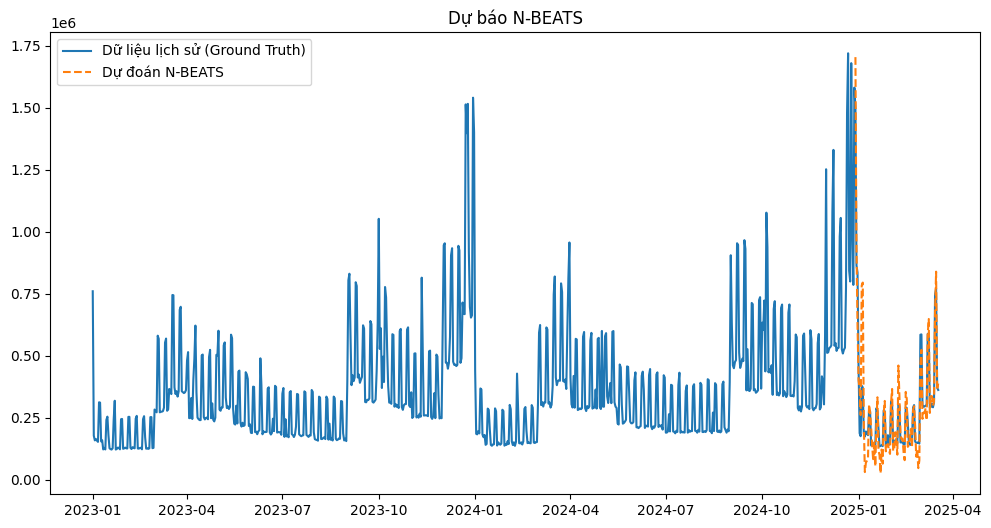

In [ ]:
# Nối DataFrame dự đoán vào cuối DataFrame gốc để vẽ đồ thị
# 'auto_predict' tự động căn chỉnh ngày tháng cho bạn
plot_df = pd.concat([df_final, predictions_df]).set_index('ds')

plt.figure(figsize=(12, 6))
# Vẽ dữ liệu lịch sử (y)
plt.plot(plot_df['y'], label='Dữ liệu lịch sử (Ground Truth)')
# Vẽ dự đoán (NBEATS)
plt.plot(plot_df['NBEATS'], label='Dự đoán N-BEATS', linestyle='--')

plt.title('Dự báo N-BEATS')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from IPython.display import display

# Hàm đánh giá mô hình huấn luyện
def evaluate_overfitting(y_val_true, y_val_pred, y_test_true, y_test_pred):

    # Hàm tính metric an toàn (fix MAPE zero-division)
    def get_metrics(y_true, y_pred):
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2   = r2_score(y_true, y_pred)

        # MAPE safe
        eps = 1e-9
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps)))

        return [mae, rmse, r2, mape]

    # Tính metrics
    metrics_val   = get_metrics(y_val_true, y_val_pred)
    metrics_test  = get_metrics(y_test_true,  y_test_pred)

    # DataFrame
    df_compare = pd.DataFrame(
        [metrics_val, metrics_test],
        columns=['MAE', 'RMSE', 'R2 Score', 'MAPE'],
        index=['Validate', 'Test']
    )

    print("=== BẢNG SO SÁCH HIỆU SUẤT MÔ HÌNH ===")
    display(df_compare)


In [ ]:
# ================================
# 1. PREDICT TEST SET
# ================================
pred_test = nf.predict(df=train_df, h=len(test_df))  # hoặc dùng riêng train_df nếu bạn tách


y_test_true = test_df['y'].values
y_test_pred = pred_test['NBEATS'].values


# ================================
# 2. PREDICT VALIDATION SET
#    (dự báo bằng cách kéo dài horizon)
# ================================
train_df_val = train_df.iloc[:-val_size]
pred_val = nf.predict(df=train_df_val, h=len(val_df))

# Chỉ lấy phần đầu tiên tương ứng validation
y_val_pred = pred_val['NBEATS'].values
y_val_true = val_df['y'].values

# ================================
# 4. EVALUATE
# ================================
evaluate_overfitting(y_val_true, y_val_pred,y_test_true, y_test_pred)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

=== BẢNG SO SÁCH HIỆU SUẤT MÔ HÌNH ===


,MAE,RMSE,R2 Score,MAPE
Validate,89898.151244,164715.060057,0.689369,0.166184
Test,61474.317046,95000.388525,0.804841,0.257870


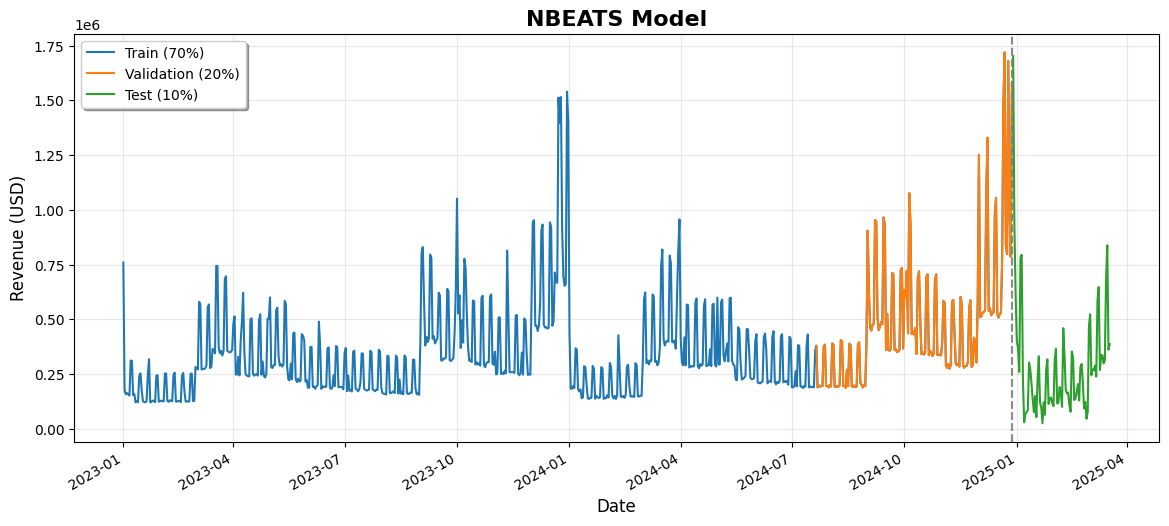

In [ ]:
import matplotlib.dates as mdates
# Thiết lập kích thước biểu đồ
plt.figure(figsize=(14, 6))

# Vẽ đường Train (Màu xanh dương)
plt.plot(train_df['ds'], train_df['y'], label='Train (70%)', color='#1f77b4', linewidth=1.5)

# Vẽ đường Validate (Màu cam)
plt.plot(val_df['ds'], val_df['y'], label='Validation (20%)', color='#ff7f0e', linewidth=1.5)

# Vẽ đường Test/Predict (Màu xanh lá)
plt.plot(test_df['ds'], predictions_df.set_index('ds')['NBEATS'], label='Test (10%)', color='#2ca02c', linewidth=1.5)

# --- Vẽ đường gạch đứt phân chia các phần ---
# Lấy ngày cuối cùng của tập Train để vẽ vạch ngăn cách 1
split_date_1 = train_df['ds'].iloc[-1]
plt.axvline(x=split_date_1, color='gray', linestyle='--', alpha=0.7)

# Lấy ngày cuối cùng của tập Val để vẽ vạch ngăn cách 2
split_date_2 = val_df['ds'].iloc[-1]
plt.axvline(x=split_date_2, color='gray', linestyle='--', alpha=0.7)

# --- Trang trí biểu đồ ---
plt.title('NBEATS Model', fontsize=16, fontweight='bold')
plt.ylabel('Revenue (USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True) # Hộp chú thích
plt.grid(True, alpha=0.3) # Lưới mờ nền sau

# Format trục ngày tháng cho dễ nhìn (nghiêng 45 độ)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

# Hiển thị
plt.show()